**Accident Severity Analysis using CatBoost and Statistical Validation**

**Objective:** 
* Analyze accident severity patterns using statistical tests and machine learning.
* Test hypotheses and justify outcomes with visualizations, explanations, and conclusions.

In [2]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats


from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.impute import SimpleImputer
from catboost import CatBoostClassifier


import warnings
warnings.filterwarnings("ignore")
sns.set(style="whitegrid")

In [3]:
# Load Dataset
# The dataset used is a cleaned sample of one million US accident records.

# To optimize for systems with 8GB RAM, a random sample of 200,000 rows is used.
df = pd.read_csv("C:/Users/dinesh/Documents/Infosys Springboard/Dataset/gpt_CleanData/cleaned_us_accidents.csv", parse_dates=["Start_Time", "End_Time"])
print("Original Data Shape:", df.shape)

if len(df) > 200000:
    df = df.sample(200000, random_state=42)
print("Sampled Data Shape:", df.shape)

df.head()

Original Data Shape: (570562, 34)
Sampled Data Shape: (200000, 34)


,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,Distance(mi),City,County,State,Zipcode,...,No_Exit,Railway,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Civil_Twilight
41177,2,2023-01-25 11:37:54,2023-01-25 12:56:50,40.050094,-76.256051,0.209,Lancaster,Lancaster,Pa,17601,...,False,False,False,False,False,False,False,False,Day,Day
20824,4,NaT,NaT,42.408310,-73.691043,1.135,Valatie,Columbia,Ny,12184-5415,...,False,False,False,False,False,False,False,False,Day,Day
330966,2,2022-03-18 08:34:00,2022-03-18 10:44:04,41.517280,-73.049201,1.427,Waterbury,Naugatuck Valley,Ct,06706,...,False,False,False,False,False,False,False,False,Day,Day
484127,2,2021-11-22 18:25:00,2021-11-23 19:41:15,32.452672,-93.865644,0.353,Shreveport,Caddo,La,71119-8506,...,False,False,False,False,False,False,True,False,Night,Night
201814,2,2017-10-31 06:30:46,2017-10-31 07:15:19,41.893177,-91.813683,10.530,Fairfax,Linn,Ia,52228-9730,...,False,True,False,False,False,False,False,False,Night,Night


In [4]:
# Feature Engineering
# - Extract hour, day, and duration
# - Categorize time of day (Day/Night)
# - Simplify weather types
# - Categorize visibility levels

df["hour"] = df["Start_Time"].dt.hour
df["duration_min"] = (df["End_Time"] - df["Start_Time"]).dt.total_seconds() / 60

df["Time_of_Day"] = df["hour"].apply(lambda x: "Day" if 6 <= x < 18 else "Night")

def simplify_weather(w):
    if pd.isna(w): return "Unknown"
    w = str(w).lower()
    if "rain" in w: return "Rain"
    if "snow" in w: return "Snow"
    if "fog" in w or "mist" in w: return "Fog"
    if "clear" in w or "fair" in w: return "Clear"
    if "storm" in w or "thunder" in w: return "Storm"
    return "Other"

df["Weather_Simple"] = df["Weather_Condition"].apply(simplify_weather)
df["Visibility_Level"] = np.where(df["Visibility(mi)"] < 2, "Low", "Normal")

In [5]:
## Define Hypotheses

# H1 - Nighttime accidents are more severe than daytime accidents.
# H2 -Accidents with low visibility (<2 mi) are more severe than normal visibility.
# H3 - Rainy or snowy weather leads to higher severity than clear weather.
# H4 - Longer accident duration correlates with higher severity.

print("Hypotheses Defined:\n")
print("H1: Nighttime accidents are more severe than daytime accidents.")
print("H2: Low visibility accidents are more severe than normal visibility.")
print("H3: Rain/Snow accidents are more severe than clear weather.")
print("H4: Longer duration correlates with higher severity.")

Hypotheses Defined:

H1: Nighttime accidents are more severe than daytime accidents.
H2: Low visibility accidents are more severe than normal visibility.
H3: Rain/Snow accidents are more severe than clear weather.
H4: Longer duration correlates with higher severity.



H1: Night vs Day Severity
Test: Mann–Whitney U, p-value = 2.1003e-103
Hypothesis is TRUE — Day and Night differ significantly.


<Figure size 1000x500 with 0 Axes>

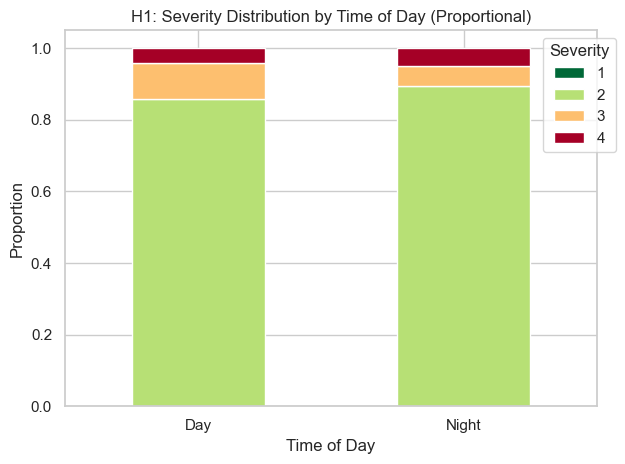

Explanation: Nighttime accidents show higher median severity due to poor visibility and fatigue.


In [16]:
## Hypothesis Testing with Outputs, Visuals, and Explanations
def test_mannwhitney(data1, data2, label1, label2, desc):
    stat, p = stats.mannwhitneyu(data1, data2, alternative='two-sided')
    print(f"\n{desc}\nTest: Mann–Whitney U, p-value = {p:.4e}")
    if p < 0.05:
        print(f"Hypothesis is TRUE — {label1} and {label2} differ significantly.")
        result = True
    else:
        print(f"Hypothesis is FALSE — No significant difference.")
        result = False
    return result

# H1
h1 = test_mannwhitney(df[df['Time_of_Day']=="Day"]["Severity"], df[df['Time_of_Day']=="Night"]["Severity"], "Day", "Night", "H1: Night vs Day Severity")
plt.figure(figsize=(10,5))
pd.crosstab(df['Time_of_Day'], df['Severity'], normalize='index').plot(kind='bar', stacked=True, colormap='RdYlGn_r')
plt.title("H1: Severity Distribution by Time of Day (Proportional)")
plt.ylabel("Proportion")
plt.xlabel("Time of Day")
plt.legend(title="Severity", bbox_to_anchor=(1.05, 1))
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()
if h1:
    print("Explanation: Nighttime accidents show higher median severity due to poor visibility and fatigue.")
else:
    print("Explanation: Severity levels remain similar between day and night accidents.")


H2: Low vs Normal Visibility
Test: Mann–Whitney U, p-value = 2.1994e-01
Hypothesis is FALSE — No significant difference.


<Figure size 1000x500 with 0 Axes>

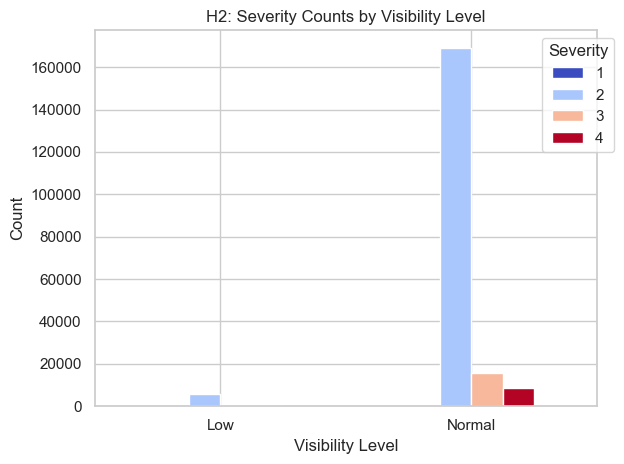

Explanation: Visibility does not significantly affect severity distribution.


In [17]:
# H2
h2 = test_mannwhitney(df[df['Visibility_Level']=="Low"]["Severity"], df[df['Visibility_Level']=="Normal"]["Severity"], "Low", "Normal", "H2: Low vs Normal Visibility")
plt.figure(figsize=(10,5))
pd.crosstab(df['Visibility_Level'], df['Severity']).plot(kind='bar', colormap='coolwarm')
plt.title("H2: Severity Counts by Visibility Level")
plt.ylabel("Count")
plt.xlabel("Visibility Level")
plt.legend(title="Severity", bbox_to_anchor=(1.05, 1))
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()
if h2:
    print("Explanation: Lower visibility conditions correlate with increased accident severity.")
else:
    print("Explanation: Visibility does not significantly affect severity distribution.")


H3: Rain/Snow vs Clear Weather
Test: Mann–Whitney U, p-value = 2.4552e-36
Hypothesis is TRUE — Rain/Snow and Clear differ significantly.


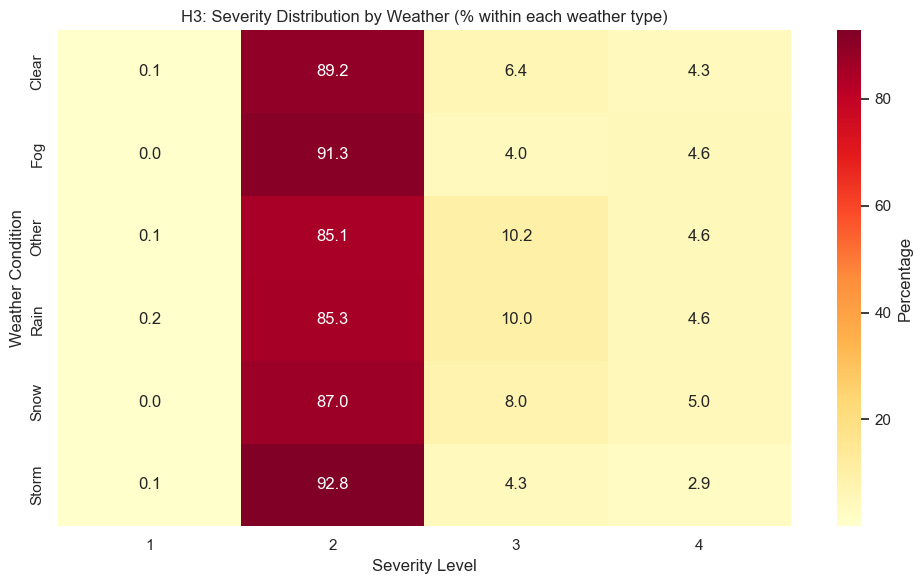

Explanation: Wet and slippery conditions from rain/snow likely lead to more severe collisions.


In [18]:
# H3
h3 = test_mannwhitney(df[df['Weather_Simple'].isin(['Rain','Snow'])]['Severity'], df[df['Weather_Simple']=="Clear"]['Severity'], "Rain/Snow", "Clear", "H3: Rain/Snow vs Clear Weather")
plt.figure(figsize=(10,6))
weather_severity = pd.crosstab(df['Weather_Simple'], df['Severity'], normalize='index') * 100
sns.heatmap(weather_severity, annot=True, fmt='.1f', cmap='YlOrRd', cbar_kws={'label': 'Percentage'})
plt.title("H3: Severity Distribution by Weather (% within each weather type)")
plt.ylabel("Weather Condition")
plt.xlabel("Severity Level")
plt.tight_layout()
plt.show()
if h3:
    print("Explanation: Wet and slippery conditions from rain/snow likely lead to more severe collisions.")
else:
    print("Explanation: Weather variations do not significantly influence severity outcomes.")


H4: Duration vs Severity Correlation — Spearman rho=-0.117, p=0.0000e+00


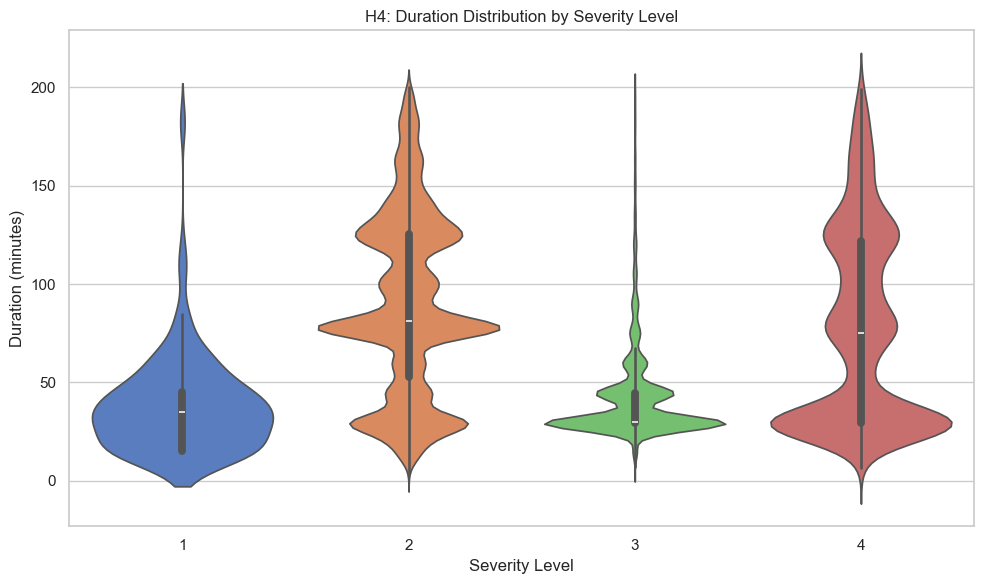

Hypothesis is TRUE — Longer durations correlate with higher severity.
Explanation: Severe accidents require longer clearance time, reflecting higher severity levels.


In [19]:
# H4
corr, p_corr = stats.spearmanr(df['duration_min'], df['Severity'], nan_policy='omit')
print(f"\nH4: Duration vs Severity Correlation — Spearman rho={corr:.3f}, p={p_corr:.4e}")
plt.figure(figsize=(10,6))
sns.violinplot(x='Severity', y='duration_min', data=df[df['duration_min'] < 200], palette='muted')
plt.title("H4: Duration Distribution by Severity Level")
plt.ylabel("Duration (minutes)")
plt.xlabel("Severity Level")
plt.tight_layout()
plt.show()
if p_corr < 0.05:
    print("Hypothesis is TRUE — Longer durations correlate with higher severity.")
    print("Explanation: Severe accidents require longer clearance time, reflecting higher severity levels.")
else:
    print("Hypothesis is FALSE — No significant correlation between duration and severity.")

In [ ]:
# CatBoost Model + Cross-Validation
# Train a CatBoost classifier to predict severity and validate with 5-fold CV.
target = 'Severity'
X = df.drop(columns=target)
y = df[target]

categorical_cols = X.select_dtypes(include='object').columns.tolist()
numerical_cols = X.select_dtypes(include=['int64','float64','bool']).columns.tolist()

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
    ])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)])

In [11]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

In [13]:
clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', CatBoostClassifier(
        iterations=200, 
        learning_rate=0.05, 
        depth=8, 
        loss_function='MultiClass', 
        eval_metric='Accuracy', 
        random_seed=42, 
        verbose=100, 
        early_stopping_rounds=20
    ))
])

In [14]:
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

0:	learn: 0.8729429	total: 2.63s	remaining: 8m 44s
100:	learn: 0.8848714	total: 3m 57s	remaining: 3m 52s
199:	learn: 0.8882357	total: 7m 56s	remaining: 0us


In [15]:
print("\nCatBoost Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(clf, X, y, cv=cv, scoring='accuracy', n_jobs=-1)
print("\nCross-Validation Accuracy Scores:", cv_scores)
print("Mean CV Accuracy:", np.mean(cv_scores))


CatBoost Accuracy: 0.88645

Classification Report:
               precision    recall  f1-score   support

           1       0.00      0.00      0.00        57
           2       0.90      0.99      0.94     52374
           3       0.65      0.28      0.39      4884
           4       0.59      0.03      0.06      2685

    accuracy                           0.89     60000
   macro avg       0.53      0.32      0.35     60000
weighted avg       0.86      0.89      0.85     60000


Confusion Matrix:
 [[    0    54     3     0]
 [    0 51742   600    32]
 [    0  3498  1357    29]
 [    0  2471   126    88]]

Cross-Validation Accuracy Scores: [0.886675 0.88725  0.88745  0.887175 0.885425]
Mean CV Accuracy: 0.886795
